In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 2.2 MB/s eta 0:00:00a 0:00:01


#### Homework: https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark

#### Step 1: Creating a SparkSession

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("PySparkTest").getOrCreate()

#### Step 2: Creating the DataFrame

In [6]:
df = spark.read.csv('OnlineRetail.csv',header=True,escape="\"")

In [7]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2,55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3,39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2,75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3,39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3,39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

#### Step 3: Exploratory Data Analysis

In [8]:
#Counting the number of rows in the dataframe:
df.count()

541909

In [10]:
#How many unique customers are present in the dataframe?
df.select('CustomerID').distinct().count()

4373

In [11]:
#What country do most purchases come from?
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



In [13]:
#To sort this table, we can include the orderBy() clause:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|        Denmark|            9|
|         Cyprus|            8|
|          Japan|            8|
|         Sweden|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [14]:
#When was the most recent purchase made by a customer on the e-commerce platform?
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-12-10 16:21:00|
+-------------------+



In [15]:
#When was the earliest purchase made by a customer on the e-commerce platform?
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|0001-04-11 10:00:00|
+-------------------+



#### Step 4: Data Pre-processing

In [16]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2,55     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3,39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2,75     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3,39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

##### RFM is commonly used in marketing to evaluate a client’s value based on their:

1.Recency: How recently has each customer made a purchase? 
2.Frequency: How often have they bought something?
3.Monetary Value: How much money do they spend on average when making purchases?

###### Recency
First, let’s calculate the value of recency - the latest date and time a purchase was made on the platform. This can be achieved in two steps:

###### i) Assign a recency score to each customer

In [17]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

###### ii) Select the most recent purchase

In [18]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [19]:
df2.show(5,0)

+-------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5,95     |13047     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2,55     |13748     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|
|3960   |536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2,55     |17850     |United Kingdom|2012-01-10 09:32:00|2012-01-10 08:26:00|
|3960   |536375   |710

In [20]:
#To view all the variables present in a PySpark dataframe
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



###### Recency
How often a customer bought something on the platform.

In [22]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [23]:
#Look at the head of this new dataframe we just created:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|15271     |24       |
|15555     |37       |
|16320     |47       |
+----------+---------+
only showing top 5 rows



In [24]:
#Join the new dataframe with the previous one
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [25]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



###### Monetary Value
The total amount spent by each customer in the dataframe. 

###### i) Find the total amount spent in each purchase:
###### Each customerID comes with variables called “Quantity” and “UnitPrice” for a single purchase:

In [26]:
#To get the total amount spent by each customer in one purchase:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

###### ii) Find the total amount spent by each customer:

In [27]:
#We just need to group by the CustomerID column and sum the total amount spent
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [28]:
#Merge this dataframe with the all the other variables:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

##### To select only the required columns and drop duplicate rows from the dataframe:

In [32]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [34]:
finaldf.show(5,0)

+------------+---------+--------------+----------+
|recency     |frequency|monetary_value|CustomerID|
+------------+---------+--------------+----------+
|5580        |14       |null          |16250     |
|2704800     |121      |null          |15574     |
|21100860    |24       |null          |15271     |
|21112020    |37       |null          |15555     |
|-63311043300|47       |null          |16320     |
+------------+---------+--------------+----------+
only showing top 5 rows



In [36]:
finaldf = finaldf.na.drop(subset=["monetary_value"])

In [37]:
finaldf.printSchema()

root
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary_value: double (nullable = true)
 |-- CustomerID: string (nullable = true)



#### Standardization

In [38]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [39]:
data_scale_output.select('standardized').show(2,truncate=False)

+--------------------------------------------------------------+
|standardized                                                  |
+--------------------------------------------------------------+
|[-0.0015898112497777397,0.11421176036732086,1.378424954243093]|
|[-0.0019430583170315387,1.4657175913806177,0.3063166564984651]|
+--------------------------------------------------------------+
only showing top 2 rows



#### Step 5: Building the Machine Learning Model

##### i) Finding the number of clusters to use

In [43]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

###### With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 10 clusters. The results have been placed in an array, and can now be visualized in a line chart:

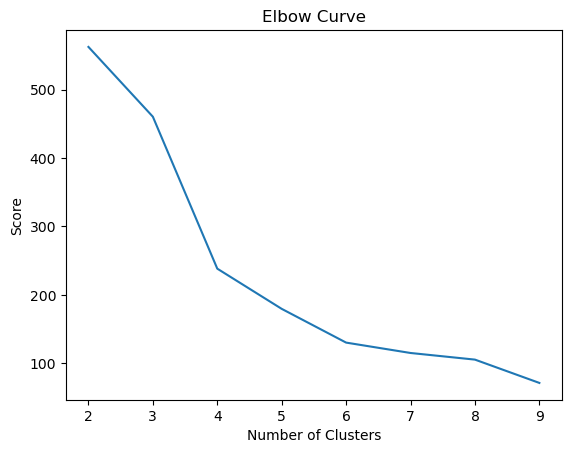

In [44]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##### ii) Building the K-Means Clustering Model

In [45]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

##### iii) Making Predictions

In [46]:
preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

+------------+---------+--------------+----------+---------------------------+--------------------------------------------------------------+----------+
|recency     |frequency|monetary_value|CustomerID|features                   |standardized                                                  |prediction|
+------------+---------+--------------+----------+---------------------------+--------------------------------------------------------------+----------+
|-47348280   |6        |162.0         |12394     |[-4.734828E7,6.0,162.0]    |[-0.0015898112497777397,0.11421176036732086,1.378424954243093]|0         |
|-57868800   |77       |36.0          |12637     |[-5.78688E7,77.0,36.0]     |[-0.0019430583170315387,1.4657175913806177,0.3063166564984651]|0         |
|-63200636760|29       |36.0          |12710     |[-6.320063676E10,29.0,36.0]|[-2.122085180584481,0.5520235084420508,0.3063166564984651]    |2         |
|-63198042300|14       |40.0          |12816     |[-6.31980423E10,14.0,40.0] |[-2.

##### Step 6: Cluster Analysis

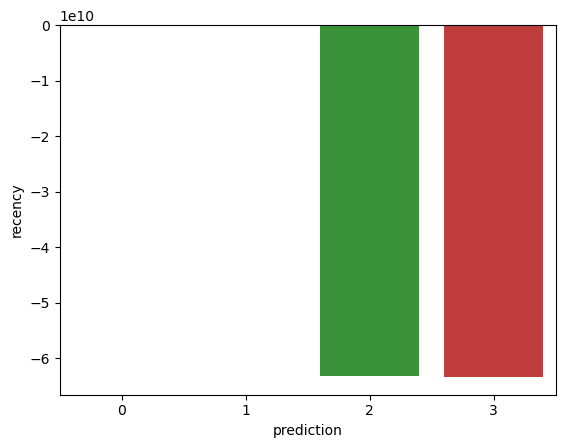

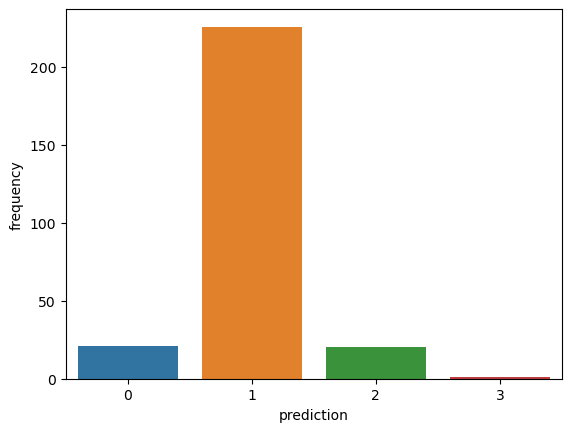

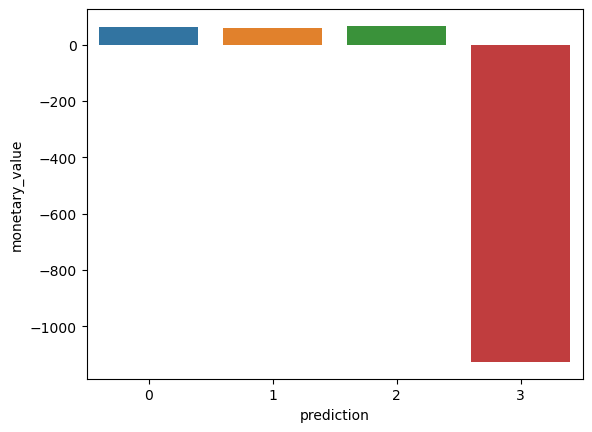

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()